#  Telecom Churn - ML Froup Case Study

authors : Seetharam Rao | Jesal Patel

# Business Problem Overview
* In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.
* For many incumbent operators, retaining high profitable customers is the number one business goal.
* To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [ ]:
import sys
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
sys.path.append('/content/drive/My Drive/Telecom_Churn_Casestudy/')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

pd.set_option("display.max_columns",100)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Import Decision Tree Classifier machine learning Library
from sklearn.tree import DecisionTreeClassifier

# Import AdaBoost machine learning library
from sklearn.ensemble import AdaBoostClassifier

# Import Logistic Regression machine learning library
from sklearn.linear_model import LogisticRegression

# Import metrics
from sklearn.feature_selection import RFE
from sklearn import metrics

# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Define random seed constant
rand_state = 101

# Data Import

In [ ]:
path = '/content/drive/My Drive/Telecom_Churn_Casestudy/telecom_churn_data.csv'
telecom_data = pd.read_csv(path)
print(f"Dataset shape and size:-{telecom_data.shape} \n")
telecom_data.info()

Dataset shape and size:-(99999, 226) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


#Data Cleaning and EDA
### Exploring Dataset Statistics 

In [ ]:
telecom_data.dtypes

mobile_number       int64
circle_id           int64
loc_og_t2o_mou    float64
std_og_t2o_mou    float64
loc_ic_t2o_mou    float64
                   ...   
aon                 int64
aug_vbc_3g        float64
jul_vbc_3g        float64
jun_vbc_3g        float64
sep_vbc_3g        float64
Length: 226, dtype: object

In [ ]:
cat_cols = list(telecom_data.select_dtypes(include=['object']).columns)
print("number of categorical columns = {} ".format(len(cat_cols)))
#print(f"{list(cat_cols)}")
num_cols = list(telecom_data.select_dtypes(include=['int','float']).columns)
print("number of continuous columns = {} ".format(len(num_cols)))
#print(list(num_cols))

number of categorical columns = 12 
number of continuous columns = 214 


In [ ]:
# calculating the null percentage of each column
null_values = pd.DataFrame({'null_val':round(100*telecom_data.isnull().sum()/len(telecom_data),2)})
null_values = null_values[null_values['null_val']>0]
print(f"Number of columns with null values :- {null_values.shape[0]}")
null_values.sort_values(by='null_val',ascending=False).head()

Number of columns with null values :- 166


,null_val
count_rech_2g_6,74.85
max_rech_data_6,74.85
arpu_3g_6,74.85
av_rech_amt_data_6,74.85
count_rech_3g_6,74.85


In [ ]:
#Listing columns having more than 50% of NA data
set_null_percent = 50
null_values = null_values.loc[null_values['null_val']>set_null_percent]
print(f"Number of columns with null values > 50% :- {null_values.shape[0]}")
null_values.sort_values(by='null_val',ascending=True).head()

Number of columns with null values > 50% :- 40


,null_val
date_of_last_rech_data_8,73.66
night_pck_user_8,73.66
arpu_2g_8,73.66
total_rech_data_8,73.66
arpu_3g_8,73.66


In [ ]:
# Here date time columns are not of use because we are not dealing with time-series data
cols_date_time = telecom_data.columns[telecom_data.columns.str.contains(pat = 'date_')] 
print(f"Droping time-series data \n\n{cols_date_time}")
# Dropping the above date-time related columns
telecom_data.drop(columns= cols_date_time,inplace=True)
print(f"\nNo of columns after dropping time-series data :- {telecom_data.shape[1]}")

Droping time-series data 

Index(['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_9',
       'date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9'],
      dtype='object')

No of columns after dropping time-series data :- 214


In [ ]:
# droping columns having unique values, doen't add info for model building
unique_list = telecom_data.columns[(telecom_data.nunique() == 1)]
print(f"Columns containing single unique values :-\n\n{unique_list}")
telecom_data.drop(columns=unique_list,inplace=True)
print(f"\nNo of columns after dropping 1 Unique value columns:- {telecom_data.shape[1]}")

Columns containing single unique values :-

Index(['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8',
       'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7',
       'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9'],
      dtype='object')

No of columns after dropping 1 Unique value columns:- 202


In [ ]:
# Unique levels of data in columns
print(f"Number of Columns having 2 unique value :- \n")
column = list(telecom_data.columns)
column_multi_lev = []
cat_levels = [0,2]
for var in range(len(telecom_data.columns)):
    if ((telecom_data[column[var]].nunique()<= cat_levels[1]) & (telecom_data[column[var]].nunique()> cat_levels[0])):
        print(column[var],telecom_data[column[var]].unique(),telecom_data[column[var]].nunique())
        column_multi_lev.append(column[var])

Number of Columns having 2 unique value :- 

night_pck_user_6 [ 0. nan  1.] 2
night_pck_user_7 [ 0. nan  1.] 2
night_pck_user_8 [ 0. nan  1.] 2
night_pck_user_9 [nan  0.  1.] 2
fb_user_6 [ 1. nan  0.] 2
fb_user_7 [ 1. nan  0.] 2
fb_user_8 [ 1. nan  0.] 2
fb_user_9 [nan  1.  0.] 2


In [ ]:
print(f"Replacing nan with zero for categorical-2 columns\n")
telecom_data[column_multi_lev] = telecom_data[column_multi_lev].fillna(0, axis=1)
telecom_data[column_multi_lev].describe().T

Replacing nan with zero for categorical-2 columns



,count,mean,std,min,25%,50%,75%,max
night_pck_user_6,99999.0,0.006310,0.079185,0.0,0.0,0.0,0.0,1.0
night_pck_user_7,99999.0,0.005890,0.076521,0.0,0.0,0.0,0.0,1.0
night_pck_user_8,99999.0,0.005490,0.073892,0.0,0.0,0.0,0.0,1.0
night_pck_user_9,99999.0,0.004140,0.064210,0.0,0.0,0.0,0.0,1.0
fb_user_6,99999.0,0.230002,0.420836,0.0,0.0,0.0,0.0,1.0
fb_user_7,99999.0,0.232382,0.422354,0.0,0.0,0.0,0.0,1.0
fb_user_8,99999.0,0.234632,0.423771,0.0,0.0,0.0,0.0,1.0
fb_user_9,99999.0,0.223182,0.416382,0.0,0.0,0.0,0.0,1.0


In [ ]:
# Renaming the columns as per standard notation
cols_rename = telecom_data.columns[telecom_data.columns.str.contains(pat = '_vbc_')] 
print(cols_rename)
telecom_data = telecom_data.rename(columns = {'aug_vbc_3g': "vbc_3g_8", 'jul_vbc_3g':"vbc_3g_7", \
                                              'jun_vbc_3g':"vbc_3g_6", 'sep_vbc_3g':"vbc_3g_9"})

Index(['aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'], dtype='object')


In [ ]:
# calculating the null percentage column having greater than 50%
cutt_off_val = 50.0
null_values = pd.DataFrame({'null_val':round(100*telecom_data.isnull().sum()/len(telecom_data),2)})
null_values = null_values.loc[null_values['null_val']>cutt_off_val]
print(f"No of columns having nan > 50% :- {null_values.shape[0]}")
null_values.sort_values(by='null_val',ascending=False).head()

No of columns having nan > 50% :- 28


,null_val
total_rech_data_6,74.85
av_rech_amt_data_6,74.85
arpu_2g_6,74.85
max_rech_data_6,74.85
count_rech_2g_6,74.85


In [ ]:
# Filling Nan with zero to seperate high customer row
hig_cust_col = ['count_rech_2g_6','count_rech_3g_6','count_rech_2g_7','count_rech_3g_7',\
               'av_rech_amt_data_6','av_rech_amt_data_7']
telecom_data[hig_cust_col] = telecom_data[hig_cust_col].fillna(0, axis=1)

In [ ]:
# sum of data recharges for the months 6,7
telecom_data['total_rech_count_data_6'] = (telecom_data['count_rech_2g_6']+\
                                           telecom_data['count_rech_3g_6'])
telecom_data['total_rech_count_data_7'] = (telecom_data['count_rech_2g_7']+\
                                           telecom_data['count_rech_3g_7'])
telecom_data['total_rech_count_data_8'] = (telecom_data['count_rech_2g_8']+\
                                           telecom_data['count_rech_3g_8'])
# total amount recharging data the months 6,7
telecom_data['total_rech_amt_data_6'] = (telecom_data['total_rech_count_data_6']\
                                          *telecom_data['av_rech_amt_data_6'])
telecom_data['total_rech_amt_data_7'] = (telecom_data['total_rech_count_data_7']\
                                         *telecom_data['av_rech_amt_data_7'])

In [ ]:
#total monthly recharge for data and call , summing amounts spents on call and data recharge for the month.
telecom_data['total_month_rech_6'] = (telecom_data['total_rech_amt_6']\
                                      +telecom_data['total_rech_amt_data_6'])
telecom_data['total_month_rech_7'] = (telecom_data['total_rech_amt_7']\
                                      +telecom_data['total_rech_amt_data_7'])
#High value customers segmentation 
high_value_cust = telecom_data[telecom_data[['total_month_rech_6','total_month_rech_7']].mean(axis=1)\
                               >=telecom_data[['total_month_rech_6','total_month_rech_7']]\
                               .mean(axis=1).quantile(0.7)]
print(f"\n\nTotal No of high value customers are :- {high_value_cust.shape[0]/1024:0.2f}k")



Total No of high value customers are :- 29.30k


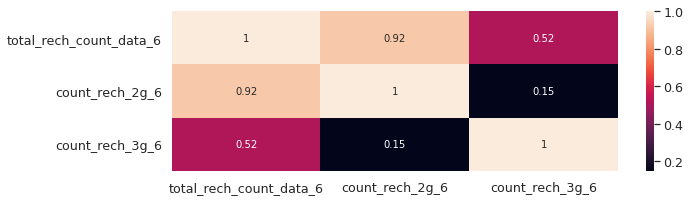

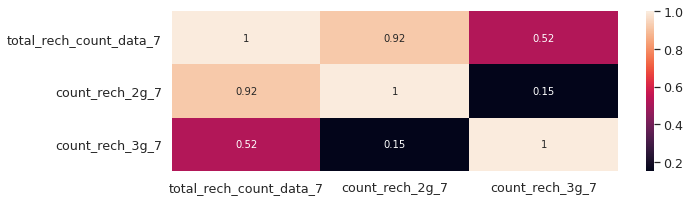

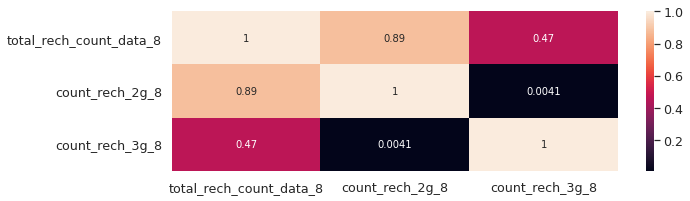

In [ ]:
for i in range(3):
    plt.figure(figsize=(10,10))
    plt.subplot(3,1,i+1)
    sns.heatmap(telecom_data[['total_rech_count_data_'+str(i+6),'count_rech_2g_'+str(i+6),'count_rech_3g_'+str(i+6)]].corr(),annot=True)
    plt.show()

In [ ]:
# Labeling Churn vs Non Churn customers
churn_col = ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
churn_dt = high_value_cust[churn_col]
high_value_cust.insert(loc=1,column='churn',value=0)
# churn customer are labelling as 1 
high_value_cust.loc[(churn_dt <= 0).all(axis=1),'churn'] = 1

In [ ]:
print(f"No of Non Churn custormers {sum(high_value_cust['churn']==0)}")
print(f"No of Churn custormers     {sum(high_value_cust['churn']==1)}")

No of Non Churn custormers 27560
No of Churn custormers     2441


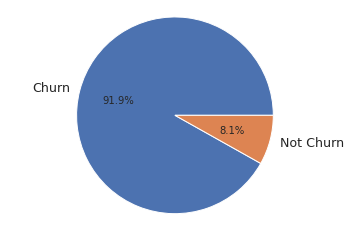

This is a class imbalance problem


In [ ]:
# Looking at the values of Yes and No's in the target variable CHURN
labels = ['Churn','Not Churn']
sizes = [high_value_cust['churn'].value_counts()[0],high_value_cust['churn'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.show()
plt.show()
print('This is a class imbalance problem')

 The average value of vol_3g_mb_9 is 349.51
 The average value of vol_2g_mb_9 is 91.44
 The average value of total_ic_mou_9 is 264.9
 The average value of total_og_mou_9 is 500.87


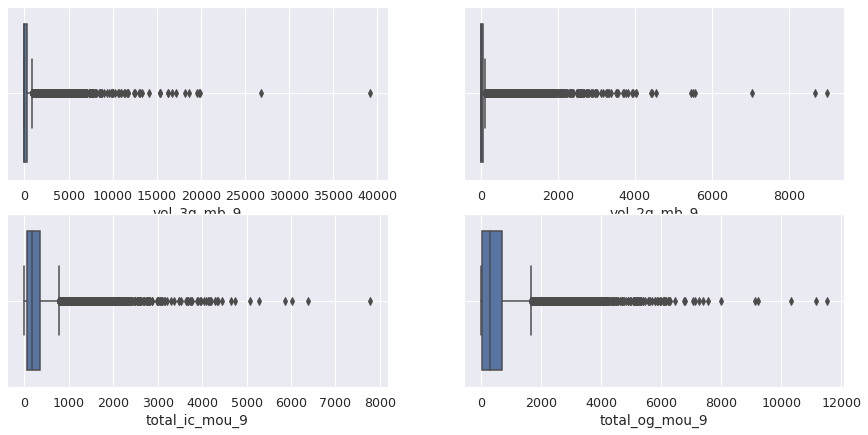

In [ ]:
#  Visualising boxplots of columns used for tagging churn
col_hv = ['vol_3g_mb_9', 'vol_2g_mb_9','total_ic_mou_9','total_og_mou_9']

plt.figure(figsize=(15,7))
for var in range(len(col_hv)):
    plt.subplot(2,2,var+1)
    sns.boxplot(high_value_cust[col_hv[var]])
    plt.grid(1)
    print(" The average value of {} is {}".format(col_hv[var],round(high_value_cust[col_hv[var]].mean(),2)))
plt.show()

In [ ]:
# drop all columns belong to 9th month  
high_value_cust.drop(columns=high_value_cust.columns\
                     [high_value_cust.columns.str.contains(pat = '_9')],inplace=True)
# dropping other unused columns
high_value_cust.drop(columns=['mobile_number'],inplace=True)
print(f"No of Columns after removing 9th month data {high_value_cust.shape[1]}")

No of Columns after removing 9th month data 159


In [ ]:
# calculating the null percentage of each column
null_values = pd.DataFrame({'null_val':round(100*high_value_cust.isnull().sum()/len(high_value_cust),2)})
null_values = null_values.loc[null_values['null_val']>0.0]
null_values.sort_values(by='null_val',ascending=False).head()

,null_val
total_rech_count_data_8,46.83
arpu_3g_8,46.83
total_rech_data_8,46.83
max_rech_data_8,46.83
count_rech_3g_8,46.83


In [ ]:
high_value_cust = high_value_cust.fillna(0,axis=1)
print(f"Filling nan values with zero")

Filling nan values with zero


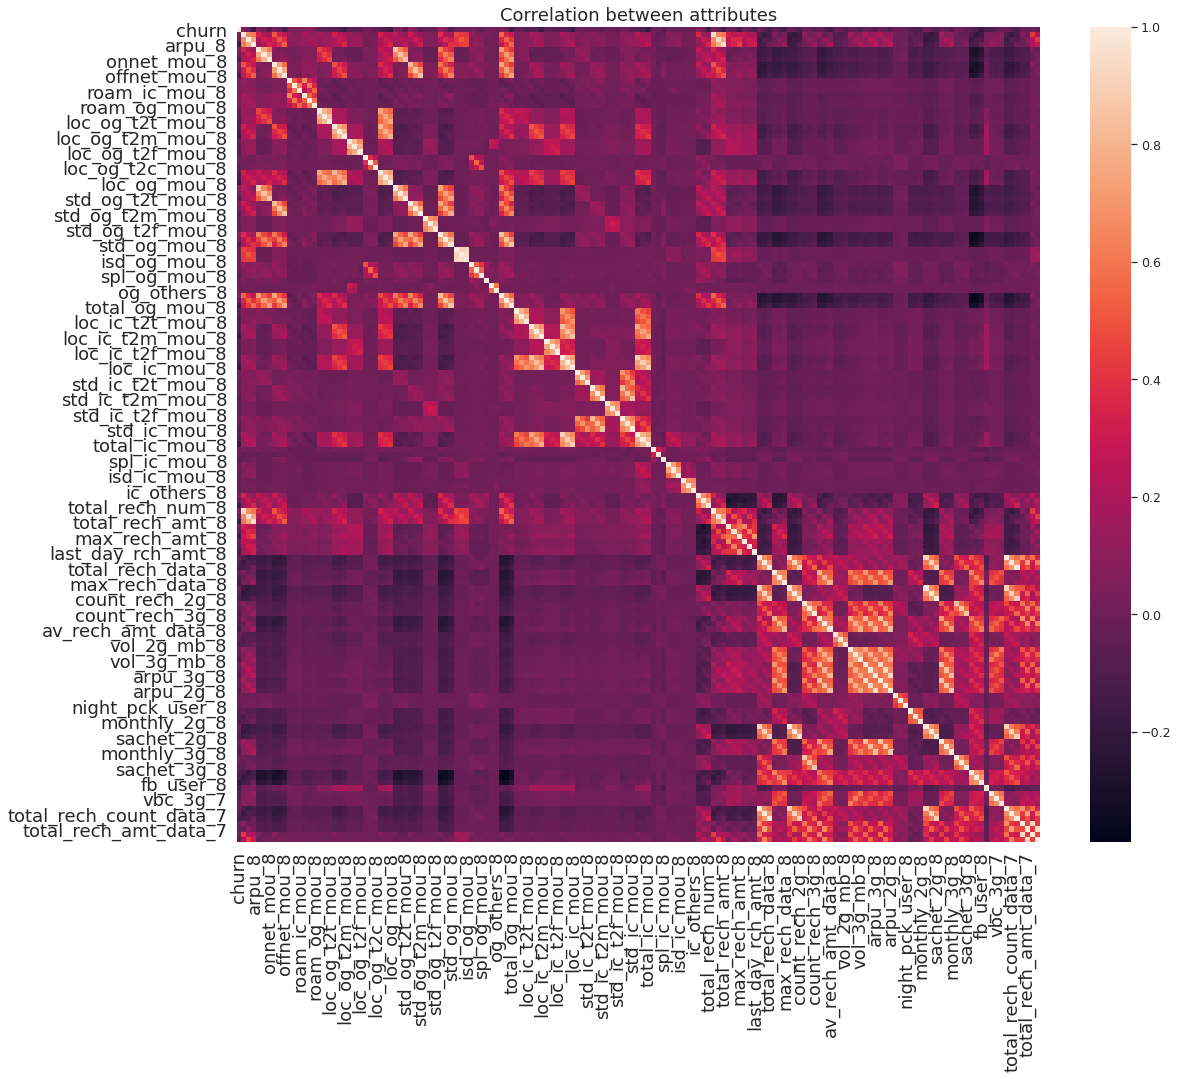

In [ ]:
# correlation plot---heatmap
sns.set(font_scale=1.15)
fig,ax=plt.subplots(figsize=(18,15))
sns.heatmap(high_value_cust.corr())
plt.title('Correlation between attributes',fontsize=18)
ax.tick_params(labelsize=18)

As we can see there are lot of correlated especially in data usage variables

##Filtering outliers


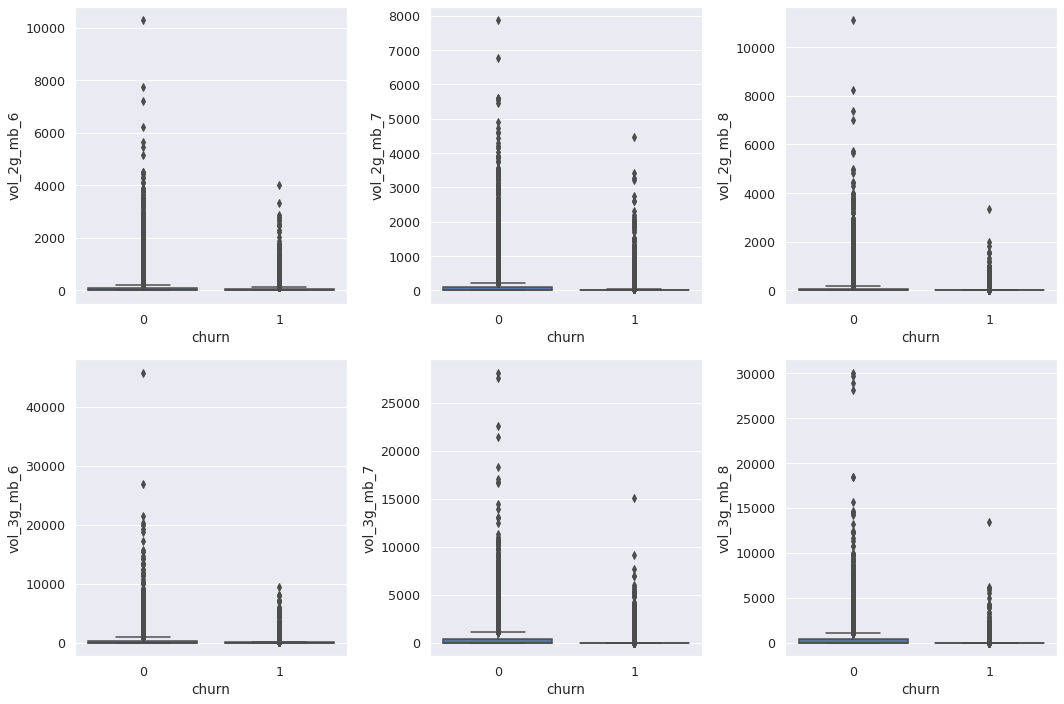

In [ ]:
fig, ax=plt.subplots(2,3,figsize=(15,10))
sns.boxplot(y='vol_2g_mb_6',x='churn',data=high_value_cust,ax=ax[0][0])
sns.boxplot(y='vol_2g_mb_7',x='churn',data=high_value_cust,ax=ax[0][1])
sns.boxplot(y='vol_2g_mb_8',x='churn',data=high_value_cust,ax=ax[0][2])
sns.boxplot(y='vol_3g_mb_6',x='churn',data=high_value_cust,ax=ax[1][0])
sns.boxplot(y='vol_3g_mb_7',x='churn',data=high_value_cust,ax=ax[1][1])
sns.boxplot(y='vol_3g_mb_8',x='churn',data=high_value_cust,ax=ax[1][2])
plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

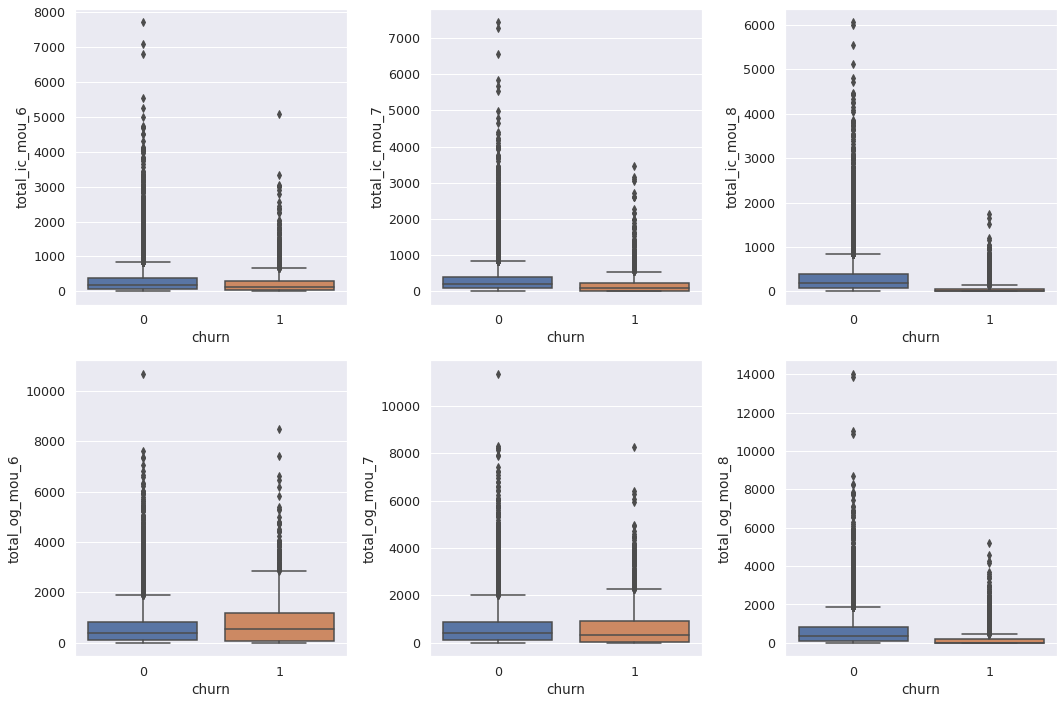

In [ ]:
fig, ax=plt.subplots(2,3,figsize=(15,10))
sns.boxplot(y='total_ic_mou_6',x='churn',data=high_value_cust,ax=ax[0][0])
sns.boxplot(y='total_ic_mou_7',x='churn',data=high_value_cust,ax=ax[0][1])
sns.boxplot(y='total_ic_mou_8',x='churn',data=high_value_cust,ax=ax[0][2])
sns.boxplot(y='total_og_mou_6',x='churn',data=high_value_cust,ax=ax[1][0])
sns.boxplot(y='total_og_mou_7',x='churn',data=high_value_cust,ax=ax[1][1])
sns.boxplot(y='total_og_mou_8',x='churn',data=high_value_cust,ax=ax[1][2])
plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

## Inference
#### From above we can drop data of ***Total_ic_mou_6*** column value above 3200 which has less churn data
#### Rest variable is also following around the same threshold

In [ ]:
### more than 3200 and above in total_ic_mou_6 and treat as outlier and don't effect much of churn data
cp_hig_val = high_value_cust.copy()
cp_hig_val.shape

(30001, 159)

In [ ]:
# caping outlier values above 3200
high_value_cust = high_value_cust[high_value_cust['total_ic_mou_6'] < 3200]
high_value_cust.shape

(29961, 159)

In [ ]:
hig_val_gh = high_value_cust.copy()

In [ ]:
print(f"No of Non Churn before outlier treatment {sum(cp_hig_val['churn']==0)}")
print(f"No of Non Churn after outlier treatment  {sum(high_value_cust['churn']==0)}\n")
print(f"No of Churn before outlier treatment {sum(cp_hig_val['churn']==1)}")
print(f"No of Churn after outlier treatment  {sum(high_value_cust['churn']==1)}")

No of Non Churn before outlier treatment 27560
No of Non Churn after outlier treatment  27522

No of Churn before outlier treatment 2441
No of Churn after outlier treatment  2439


##BoxPlot after handling Outliers

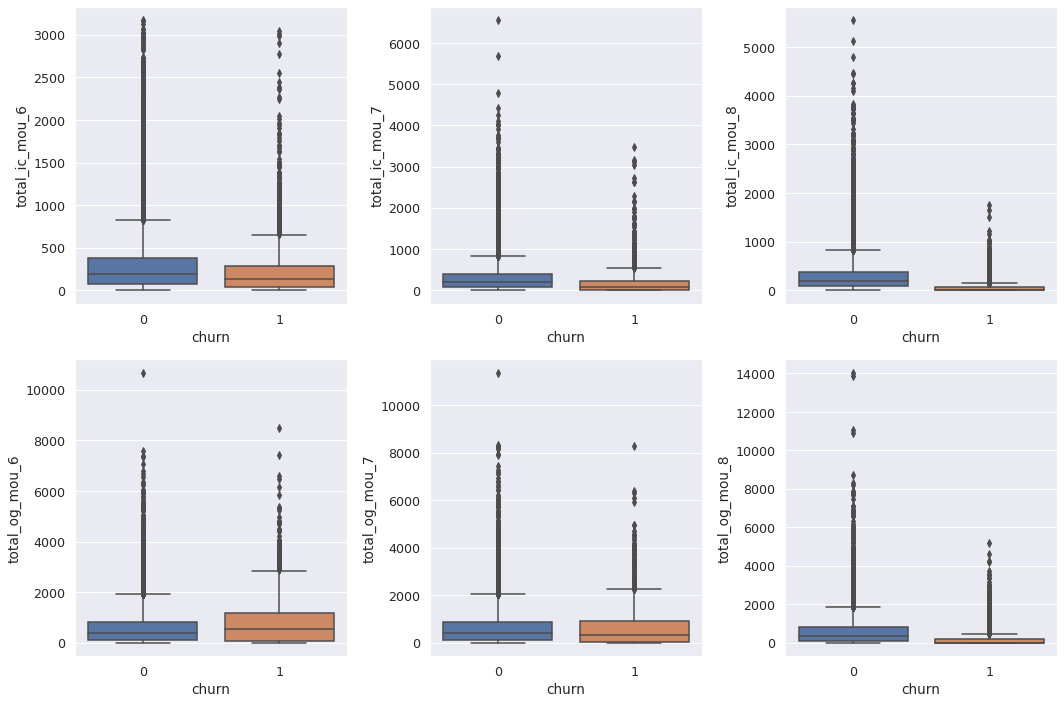

In [ ]:
fig, ax=plt.subplots(2,3,figsize=(15,10))
sns.boxplot(y='total_ic_mou_6',x='churn',data=high_value_cust,ax=ax[0][0])
sns.boxplot(y='total_ic_mou_7',x='churn',data=high_value_cust,ax=ax[0][1])
sns.boxplot(y='total_ic_mou_8',x='churn',data=high_value_cust,ax=ax[0][2])
sns.boxplot(y='total_og_mou_6',x='churn',data=high_value_cust,ax=ax[1][0])
sns.boxplot(y='total_og_mou_7',x='churn',data=high_value_cust,ax=ax[1][1])
sns.boxplot(y='total_og_mou_8',x='churn',data=high_value_cust,ax=ax[1][2])
plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

###Preparing Dataset

In [ ]:
y = high_value_cust.pop('churn')
X = high_value_cust.copy()

### Spliting dataset with 70:30 with equal class distribution ( Stratify = y labels)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,test_size = 0.3,\
                                    random_state=rand_state,stratify=y)

print(f" Train Dataset :- {X_train.shape} {y_train.shape[0]}\n \
Test  Dataset :- {X_test.shape}  {y_test.shape[0]}")

 Train Dataset :- (20972, 158) 20972
 Test  Dataset :- (8989, 158)  8989


## Preparing the dataset, normalizing using minmax scaler 

In [ ]:
# using min-max scalar for scaling the numerical terms
from sklearn.preprocessing import MinMaxScaler,StandardScaler

scalar = MinMaxScaler()
# scalar2 = StandardScaler()

Xtrain = scalar.fit_transform(X_train)
Xtest = scalar.transform(X_test)

Xtest = pd.DataFrame(Xtest, columns=X_test.columns)

print(f"Train size:- {Xtrain.shape}, Test size:- {Xtest.shape}")

Train size:- (20972, 158), Test size:- (8989, 158)


##Handling class imbalance for the Train dataset

In [ ]:
#perform oversampling using smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=rand_state)
X_train_smo, y_train_smo = sm.fit_sample(Xtrain, y_train)
Xtrain = pd.DataFrame(X_train_smo, columns=X_train.columns)
y_train = pd.DataFrame({'churn':y_train_smo})

In [ ]:
print("Train churn count       = {} ".format(sum(y_train['churn']==1)))
print("Train non_churn count   = {} \n".format(sum(y_train['churn']==0)))
print("Test churn count     = {} ".format(sum(y_test==1)))
print("Test non churn count = {} ".format(sum(y_test==0)))
print(f"\nTrain size:- {Xtrain.shape}, Test size:- {Xtest.shape}")

Train churn count       = 19265 
Train non_churn count   = 19265 

Test churn count     = 732 
Test non churn count = 8257 

Train size:- (38530, 158), Test size:- (8989, 158)


# Base model : Logistic Model
#### Implementing Logistic model using RFE feature extraction

In [ ]:
# Adding LogisticRegression base model
logreg = LogisticRegression(class_weight="balanced",n_jobs=-1,random_state=rand_state)

max_cols = 40

# running RFE 
rfe = RFE(logreg, max_cols)
rfe = rfe.fit(Xtrain,y_train)

In [ ]:
#Iterate from array de rfe.support_ and pick columns that are == True
rfe_cols = list(Xtrain.columns)
i = 0
cols = []
for e in rfe.support_:
	if e == True:
	    cols.append(rfe_cols[i])
	i = i+1
sorted(rfe_cols)

['aon',
 'arpu_2g_6',
 'arpu_2g_7',
 'arpu_2g_8',
 'arpu_3g_6',
 'arpu_3g_7',
 'arpu_3g_8',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'last_day_rch_amt_8',
 'loc_ic_mou_6',
 'loc_ic_mou_7',
 'loc_ic_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og

In [ ]:
X_train_rfe = Xtrain[rfe_cols]
X_train_rfe.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,...,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,vbc_3g_8,vbc_3g_7,vbc_3g_6,total_rech_count_data_6,total_rech_count_data_7,total_rech_count_data_8,total_rech_amt_data_6,total_rech_amt_data_7,total_month_rech_6,total_month_rech_7
count,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,...,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.00000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000,38530.000000
mean,0.149997,0.089931,0.064981,0.042530,0.032784,0.016025,0.047837,0.043494,0.016877,0.007738,0.006000,0.004021,0.009348,0.010732,0.005359,0.010758,0.008792,0.004475,0.028751,0.027211,0.018999,0.003270,0.003798,0.006083,0.005544,0.003213,0.003643,0.019728,0.025596,0.013221,0.030716,0.023664,0.015086,0.027611,0.025048,0.008346,0.002172,0.002721,0.001916,0.052838,0.048494,0.016442,0.000480,0.000365,0.000234,0.005910,0.005438,0.004942,0.009305,0.000226,...,0.029947,0.024562,0.022727,0.014888,0.011462,0.009264,0.015971,0.026320,0.019614,0.011755,0.015993,0.008116,0.006872,0.010326,0.007512,0.014895,0.015174,0.014901,0.012126,0.014256,0.018174,0.01444,0.010123,0.007354,0.033733,0.026333,0.018671,0.026487,0.021819,0.019981,0.015018,0.011798,0.008699,0.007637,0.006068,0.004625,0.481994,0.453526,0.326694,0.208469,0.008245,0.014664,0.012283,0.026224,0.032920,0.018432,0.003993,0.009748,0.009839,0.021059
std,0.026349,0.023292,0.021479,0.071285,0.059161,0.036700,0.062976,0.062165,0.029097,0.034830,0.028766,0.019245,0.038330,0.041846,0.022870,0.029670,0.026522,0.016081,0.046935,0.046206,0.037937,0.016246,0.017616,0.024245,0.020552,0.015183,0.016966,0.030988,0.042467,0.026455,0.066370,0.054609,0.046072,0.057106,0.056213,0.024122,0.016053,0.020644,0.016713,0.082

In [ ]:
# Fitting model on RFE features
log_rfe = LogisticRegression(class_weight="balanced",n_jobs=-1,random_state=rand_state)
log_rfe.fit(X_train_rfe,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=101, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#Predict on training set
y_train_pred = log_rfe.predict(X_train_rfe)
y_train_pred_prob = log_rfe.predict_proba(X_train_rfe)[:,1]

In [ ]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(6, 6))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, thresholds

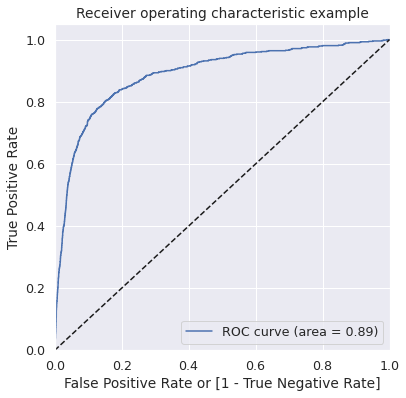

Logistic Regression using RFE Test Score :- 0.89


In [ ]:
pred_probs_test = log_rfe.predict_proba(Xtest[X_train_rfe.columns])
draw_roc(y_test,pred_probs_test[:,1])
print(f"Logistic Regression using RFE Test Score :- {metrics.roc_auc_score(y_test, pred_probs_test[:,1]):2.2f}")

In [ ]:
#checking with probability cutoff
prob_cutoff = 0.50

y_train_pred = log_rfe.predict_proba(X_train_rfe)[:,1]
y_train_pred_final = pd.DataFrame({'Churn':y_train_smo, 'Churn_Prob':y_train_pred})
y_train_pred_final['Churn_Prob'] = y_train_pred
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > prob_cutoff else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted
0,0,0.316484,0
1,0,0.113884,0
2,0,0.325736,0
3,0,0.000059,0
4,0,0.752607,1


#### Tuning of probability value for model

In [ ]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.316484,0,1,1,1,1,0,0,0,0,0,0
1,0,0.113884,0,1,1,0,0,0,0,0,0,0,0
2,0,0.325736,0,1,1,1,1,0,0,0,0,0,0
3,0,0.000059,0,1,0,0,0,0,0,0,0,0,0
4,0,0.752607,1,1,1,1,1,1,1,1,1,0,0


In [ ]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.500000  1.000000  0.000000
0.1   0.1  0.688554  0.982870  0.394238
0.2   0.2  0.758656  0.959668  0.557643
0.3   0.3  0.802284  0.933039  0.671529
0.4   0.4  0.827874  0.896808  0.758941
0.5   0.5  0.840436  0.853413  0.827459
0.6   0.6  0.840670  0.799169  0.882170
0.7   0.7  0.824890  0.727537  0.922242
0.8   0.8  0.790994  0.628653  0.953335
0.9   0.9  0.613210  0.241215  0.985206


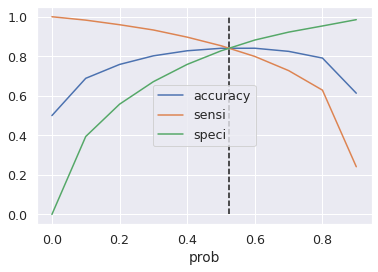

In [ ]:
#lets plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
prob_val = 0.525
plt.plot([prob_val,prob_val],[0,1], 'k--')
plt.show()

###Thershold Probability of 0.525 is giving good results

In [ ]:
#lets predict on test datset with optimal cutoff obtained earlier
y_test_pred = log_rfe.predict_proba(Xtest[X_train_rfe.columns])[:,1]
y_test_pred_final = pd.DataFrame({'Churn':y_test, 'Churn_Prob':y_test_pred})
y_test_pred_final['Churn_Prob'] = y_test_pred
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.525 else 0)
y_test_pred_final.head()

,Churn,Churn_Prob,predicted
15287,0,0.317000,0
75194,0,0.126584,0
11854,0,0.020671,0
24974,0,0.362275,0
33424,0,0.184103,0


In [ ]:
acc_LR=metrics.accuracy_score(y_test_pred_final['Churn'], y_test_pred_final['predicted'])
print("Accuracy Logistic Regression using RFE:",acc_LR)
print('Confusion Matrix LR: \n',metrics.confusion_matrix(y_test_pred_final['Churn'], y_test_pred_final['predicted']))
print('Classification report LR using RFE: \n',metrics.classification_report(y_test_pred_final['Churn'],y_test_pred_final['predicted']))  

Accuracy Logistic Regression using RFE: 0.8337968628323507
Confusion Matrix LR: 
 [[6902 1355]
 [ 139  593]]
Classification report LR using RFE: 
               precision    recall  f1-score   support

           0       0.98      0.84      0.90      8257
           1       0.30      0.81      0.44       732

    accuracy                           0.83      8989
   macro avg       0.64      0.82      0.67      8989
weighted avg       0.93      0.83      0.86      8989



In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
results = pd.DataFrame({'Method':['Logistic Regression'], 'accuracy': [acc_LR]},index={'1'})
results = results[['Method', 'accuracy']]
results

,Method,accuracy
1,Logistic Regression,0.833797


#Base Model, Feature extracting using PCA

In [ ]:
#Importing the PCA module
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

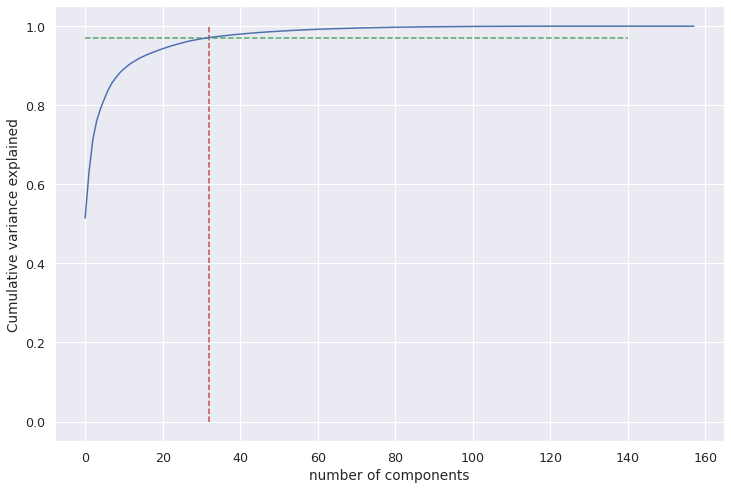

In [ ]:
pca = PCA(random_state=rand_state)
pca.fit(Xtrain)
var_cumu = np.cumsum(pca.explained_variance_ratio_)

fig = plt.figure(figsize=[12,8])
plt.vlines(x=32, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.97, xmax=140, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.xlabel('number of components')
plt.show()

###No of Columns required for 0.97% accuracy

In [ ]:
per = 97
print(f"No of columns required for {per}% accuracy is \
{(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)<per).sum()}")

No of columns required for 97% accuracy is 32


###Sorting Columns which are having Highest PCA Weightage

In [ ]:
PCcol = ['PC'+str(x) for x in range(1,159)]
components = pd.DataFrame(pca.components_,columns=PCcol,index=X_train.columns)
pca_dt = components.sort_values(by=PCcol,ascending=True)
pca_dt.head(20)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152,PC153,PC154,PC155,PC156,PC157,PC158
count_rech_2g_7,-0.641745,0.053180,-0.060783,-0.005768,-0.001410,0.006415,0.018196,0.006225,-0.012213,-0.002187,-0.000144,0.019125,-0.010662,0.004874,-0.019987,0.005306,0.002218,-0.005572,-0.012219,-0.000858,0.002695,0.038382,-0.009785,0.000305,-0.009232,-0.004010,0.006619,0.003063,0.000038,-0.004199,0.008723,0.002259,-0.005544,-0.013941,-0.003542,0.008309,0.011702,0.033121,-0.032358,-0.005646,0.000860,0.004138,-0.003701,0.000048,0.000772,0.017780,0.002265,-0.006462,-0.001008,0.006212,...,0.005695,0.001972,-0.007672,-0.005021,-0.010274,0.017535,-0.154522,-0.003874,0.061673,0.019450,-0.004870,-0.001451,0.038589,-0.000684,-0.018839,0.192115,-0.082344,0.027621,-0.083783,0.149679,-0.157086,-0.001981,-0.000643,0.001709,0.000883,0.007347,-0.017076,0.005605,0.001207,-0.005161,-0.007004,-0.019459,0.030991,-0.001640,-0.001379,0.001007,0.000008,0.000709,-0.001069,0.001019,-0.002165,0.002719,0.005430,0.001254,-0.005519,0.004653,-0.035525,0.024320,0.068755,-0.024044
spl_og_mou_7,-0.180824,-0.110434,-0.070688,-0.054287,0.025955,-0.064625,-0.025594,-0.079620,0.031415,0.413510,0.337330,0.168304,-0.145359,-0.247510,-0.123204,-0.033799,0.038925,0.025161,-0.072710,0.078339,0.140153,-0.096312,-0.094096,-0.016622,0.013073,0.012606,0.009524,-0.066000,0.069924,0.086605,0.027599,0.035363,-0.082835,0.094580,-0.038767,0.018058,0.001164,0.018112,0.047330,0.116210,-0.002802,-0.024395,-0.059333,-0.042165,-0.034871,-0.015970,-0.018214,-0.011657,0.069863,-0.073738,...,0.007915,-0.010032,-0.012070,0.000588,0.020967,0.038668,0.005931,-0.000264,-0.010279,-0.006835,0.008241,0.004215,-0.000429,-0.002915,-0.011824,0.011052,0.011775,0.006347,0.011273,0.016970,0.008488,0.006218,-0.003753,-0.002896,0.017560,0.026059,0.034135,0.006114,-0.012747,-0.017090,0.130474,0.099424,0.064332,-0.062400,-0.024484,0.004357,0.000754,-0.000013,-0.000030,-0.002068,-0.018855,-0.042057,-0.000660,0.005340,0.005256,0.013152,0.005126,0.015012,-0.025271,-0.038536
ic_others_6,-0.162962,0.106625,0.071157,0.013227,-0.010141,-0.013801,0.018862,-0.015813,-0.014946,-0.001945,-0.019674,0.059083,0.045598,-0.023873,-0.054740,0.003647,0.001433,0.008003,0.031344,-0.021814,-0.006575,0.008403,0.002258,-0.009131,0.026099,-0.039927,0.035644,0.017290,-0.011550,0.004354,0.000690,0.001163,0.003374,0.010157,-0.001689,-0.010693,0.114641,-0.015880,-0.072484,0.019132,-0.001590,-0.011551,-0.072623,0.011216,0.005447,-0.013104,-0.048611,0.029045,0.004653,0.005717,...,-0.008467,-0.013364,-0.002997,-0.136598,0.051091,0.084677,0.251490,-0.278602,-0.187470,0.030766,0.006475,-0.015347,0.224425,0.061390,-0.053382,0.281243,-0.119033,-0.138450,0.216463,-0.096223,-0.070611,-0.003842,0.000761,-0.001223,-0.010392,-0.010417,0.004902,-0.007401,-0.012279,-0.003718,-0.292612,0.127666,0.268966,0.004663,-0.007271,-0.058772,0.008741,-0.001309,-0.003378,-0.002201,0.067958,0.008766,-0.088104,-0.070353,0.023889,0.042779,0.256455,0.046662,0.211628,0.087251
spl_ic_mou_8,-0.145696,0.111488,0.037327,0.018514,-0.017543,0.016146,0.021098,-0.010540,-0.013700,-0.036572,0.040564,-0.005362,0.066325,-0.044938,-0.013646,0.000144,-0.014202,0.032998,0.032838,-0.007810,-0.028149,-0.030078,-0.007712,-0.013436,-0.034658,0.100738,-0.024518,0.010537,-0.019584,0.018773,0.003424,0.003841,-0.017801,0.011163,-0.009940,0.005654,-0.031154,0.030622,0.008704,0.011521,-0.004146,-0.003527,-0.040045,0.000361,-0.009964,-0.011292,0.071953,-0.100585,-0.001098,0.015980,...,-0.002255,0.016464,0.009924,0.029746,-0.043499,-0.029707,-0

###Top 32 columns having higher PCA values

In [ ]:
pca_col = pca_dt.index[:32]
pca_col = list(pca_col.sort_values())
pca_col

['av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'count_rech_2g_7',
 'count_rech_3g_8',
 'ic_others_6',
 'isd_og_mou_7',
 'last_day_rch_amt_6',
 'last_day_rch_amt_7',
 'loc_ic_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_8',
 'loc_og_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2f_mou_8',
 'max_rech_data_8',
 'roam_ic_mou_7',
 'spl_ic_mou_8',
 'spl_og_mou_7',
 'std_ic_mou_6',
 'std_ic_t2f_mou_8',
 'std_ic_t2m_mou_8',
 'std_ic_t2t_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2m_mou_8',
 'std_og_t2t_mou_7',
 'total_og_mou_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'total_rech_data_8',
 'total_rech_num_7',
 'vol_3g_mb_6']

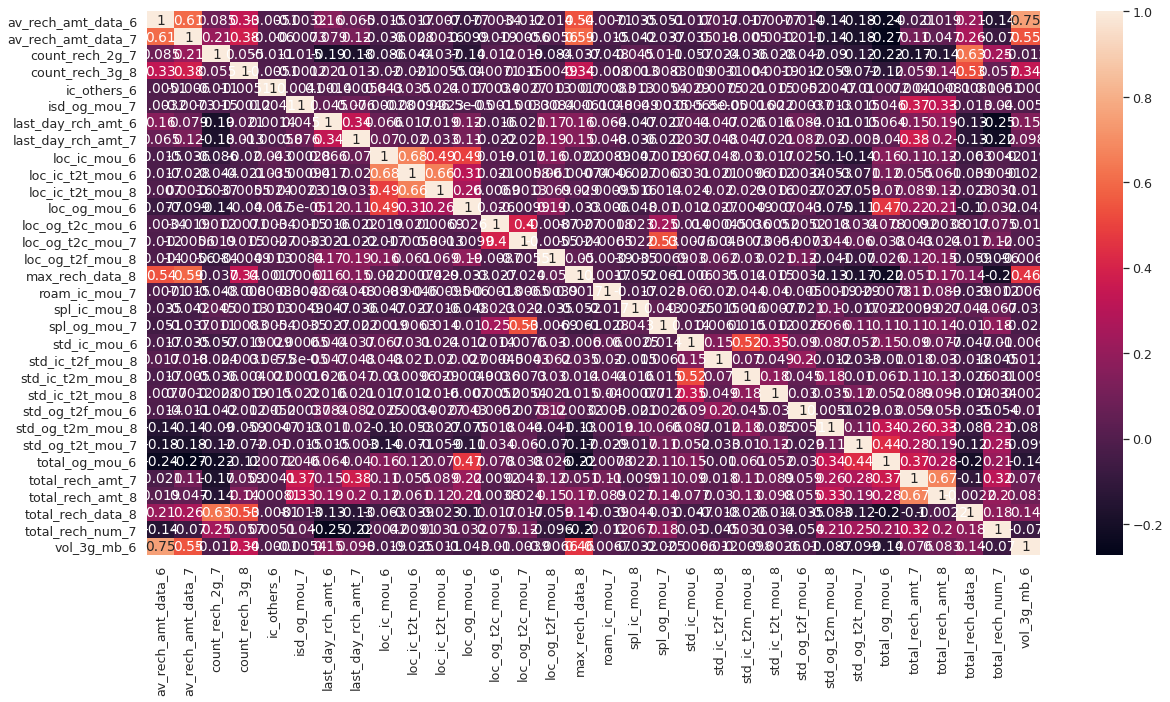

In [ ]:
# Correlation Graph of PCA columns
plt.figure(figsize = (20,10))
sns.heatmap(X_train[pca_col].corr(),annot = True)

In [ ]:
# model building Using PCA
pca_final = IncrementalPCA(n_components=32)
Xtrain_reduced = pca_final.fit_transform(Xtrain)
Xtrain_reduced.shape

(38530, 32)

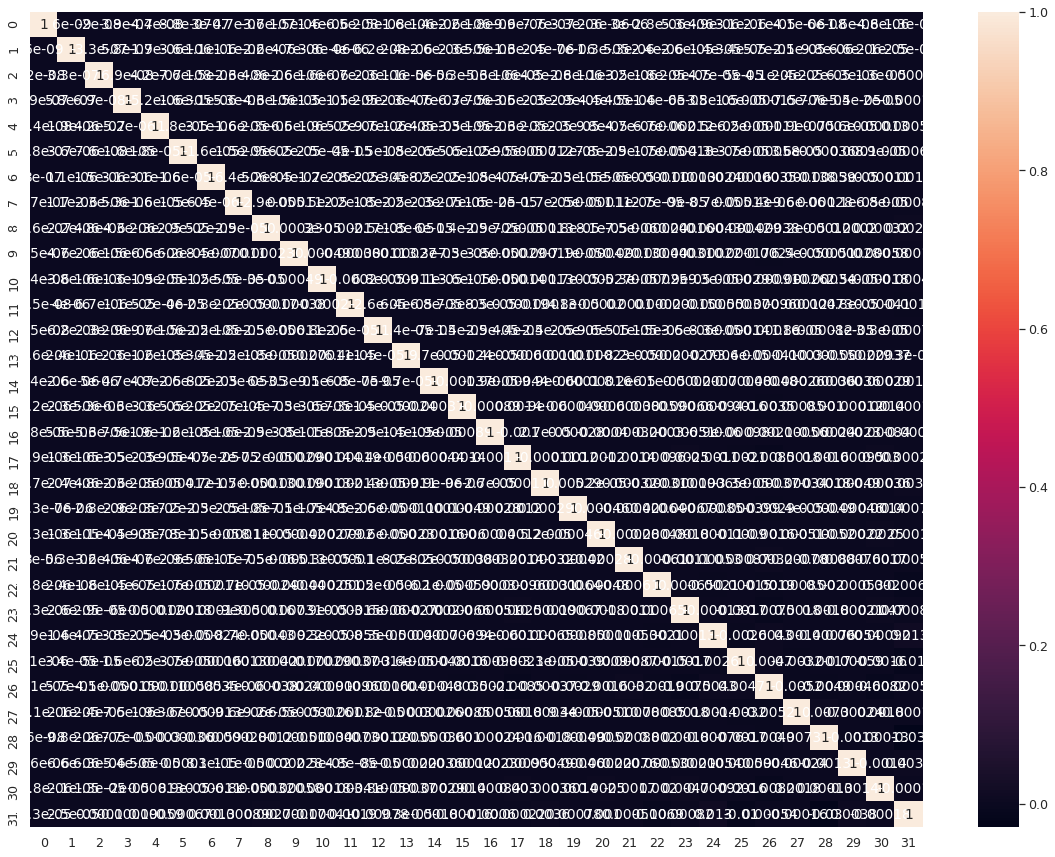

In [ ]:
corrmat = np.corrcoef(Xtrain_reduced.transpose())
plt.figure(figsize=[20,15])
sns.heatmap(corrmat, annot=True)

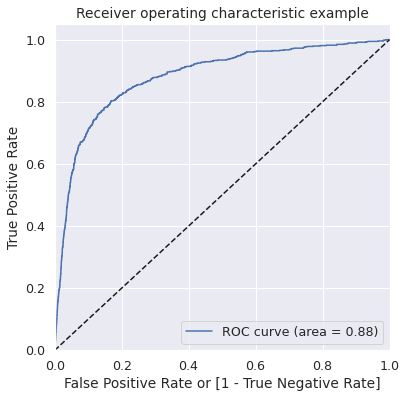


PCA Test Score :- 0.88


In [ ]:
# Applying transformation on test
Xtest_reduced = pca_final.transform(Xtest)

# Applying logistic model
learner_pca = LogisticRegression(class_weight='balanced')
pca_lr = learner_pca.fit(Xtrain_reduced, y_train)
pred_probs_test = pca_lr.predict_proba(Xtest_reduced)

draw_roc(y_test,pred_probs_test[:,1])

print(f"\nPCA Test Score :- {metrics.roc_auc_score(y_test, pred_probs_test[:,1]):2.2f}")

In [ ]:
#Evaluate the model using accuracy, confusion metrix, and classification report
pred_test = pca_lr.predict(Xtest_reduced)
pca_DT=metrics.accuracy_score(y_test, pred_test)
print('Accuracy of PCA: ',pca_DT)
print('Confusion Matrix PCA: \n',metrics.confusion_matrix(y_test, pred_test))
print('Classification report PCA: \n',metrics.classification_report(y_test, pred_test))  

Accuracy of PCA:  0.81477361219268
Confusion Matrix PCA: 
 [[6730 1527]
 [ 138  594]]
Classification report PCA: 
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      8257
           1       0.28      0.81      0.42       732

    accuracy                           0.81      8989
   macro avg       0.63      0.81      0.65      8989
weighted avg       0.92      0.81      0.85      8989



In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['PCA'], 'accuracy': pca_DT},index={'2'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'accuracy']]
results

,Method,accuracy
1,Logistic Regression,0.833797
2,PCA,0.814774


#Base Model Decision Tree

In [ ]:
# invoking the decision tree classifier function. Using 'entropy' method of finding the split columns. Other option                             
dt_model = DecisionTreeClassifier(criterion = 'entropy',random_state=rand_state,max_depth = 5)
#Fitting the model
dt_model.fit(Xtrain, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=101, splitter='best')

In [ ]:
# importance of features in the tree building 
DT_fet = pd.DataFrame(dt_model.feature_importances_, columns = ["Imp_FT"], index = X_train.columns)\
       .sort_values(by='Imp_FT',ascending=False)
DT_fet.head()

,Imp_FT
total_ic_mou_8,0.455141
roam_og_mou_8,0.170058
av_rech_amt_data_8,0.135124
last_day_rch_amt_8,0.048608
total_og_mou_8,0.041615


In [ ]:
print(DT_fet[DT_fet['Imp_FT']>0])
print(f"\nNo of Columns DT picked up coefficient greater than zero is {DT_fet[DT_fet['Imp_FT']>0].shape[0]}")

                      Imp_FT
total_ic_mou_8      0.455141
roam_og_mou_8       0.170058
av_rech_amt_data_8  0.135124
last_day_rch_amt_8  0.048608
total_og_mou_8      0.041615
roam_ic_mou_8       0.035865
total_rech_amt_8    0.035620
total_rech_num_8    0.015804
spl_og_mou_7        0.009571
loc_ic_mou_6        0.008537
loc_og_t2f_mou_7    0.008083
arpu_8              0.004830
isd_ic_mou_6        0.004346
loc_og_mou_8        0.004263
isd_og_mou_8        0.003738
monthly_3g_6        0.003563
arpu_2g_7           0.003228
monthly_2g_7        0.002836
sachet_3g_7         0.002337
total_og_mou_7      0.002293
ic_others_6         0.001915
vol_2g_mb_8         0.001871
loc_ic_t2f_mou_8    0.000753

No of Columns DT picked up coefficient greater than zero is 23


In [ ]:
#Making the prediction
y_predict = dt_model.predict(Xtest)

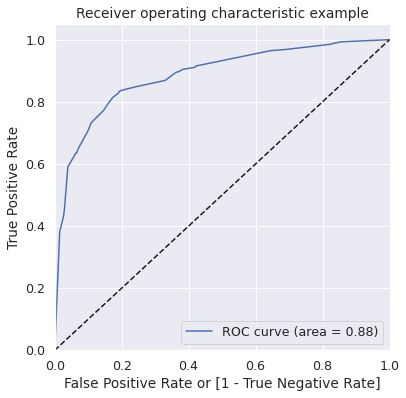


ROC of Decision Tree using Max Depth = 5 :- 0.88


In [ ]:
pred_probs_test = dt_model.predict_proba(Xtest)
draw_roc(y_test,pred_probs_test[:,1])
print(f"\nROC of Decision Tree using Max Depth = 5 :- {metrics.roc_auc_score(y_test, pred_probs_test[:,1]):2.2f}")

In [ ]:
# performance on train data
print('Performance on Training data using DT: ',dt_model.score(Xtrain , y_train))
# performance on test data
print('Performance on Testing data using DT:  ',dt_model.score(Xtest , y_test))
#Evaluate the model using accuracy, confusion metrix, and classification report
acc_DT=metrics.accuracy_score(y_test, y_predict)
print("Accuracy Pruned DT:",acc_DT)
print('Confusion Matrix Pruned DT: \n',metrics.confusion_matrix(y_test, y_predict))
print('Classification report Pruned DT: \n',metrics.classification_report(y_test, y_predict))  

Performance on Training data using DT:  0.8774720996626005
Performance on Testing data using DT:   0.8334631215930581
Accuracy Pruned DT: 0.9364779174546668
Confusion Matrix Pruned DT: 
 [[8150  107]
 [ 464  268]]
Classification report Pruned DT: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      8257
           1       0.71      0.37      0.48       732

    accuracy                           0.94      8989
   macro avg       0.83      0.68      0.73      8989
weighted avg       0.93      0.94      0.93      8989



In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Decision Tree'], 'accuracy': [acc_DT]},index={'3'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'accuracy']]
results

,Method,accuracy
1,Logistic Regression,0.833797
2,PCA,0.814774
3,Decision Tree,0.936478


#HP Random Forest

In [ ]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier(random_state=rand_state)

# fit
rfc.fit(Xtrain[pca_col],y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

In [ ]:
# Making predictions
predictions = rfc.predict(X_test[pca_col])

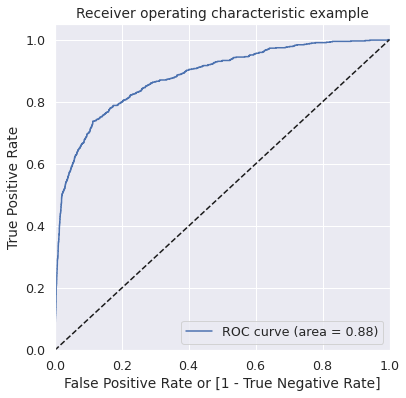


ROC of Random Forest using default configure :- 0.88


In [ ]:
pred_probs_test = rfc.predict_proba(Xtest[pca_col])
draw_roc(y_test,pred_probs_test[:,1])
print(f"\nROC of Random Forest using default configure :- {metrics.roc_auc_score(y_test, pred_probs_test[:,1]):2.2f}")

In [ ]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(5, 25, 5)}

# instantiate the model
rf = RandomForestClassifier(n_jobs=-1,random_state=rand_state)

# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True,n_jobs = -1)
rf.fit(Xtrain[pca_col], y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False, random_state=101,
                                   

In [ ]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,5.769135,0.085389,0.194528,0.041136,5,{'max_depth': 5},0.820010,0.835453,0.840903,0.831690,0.843888,0.834389,0.008341,4,0.843596,0.838275,0.837821,0.840676,0.838275,0.839729,0.002178
1,9.745432,0.119023,0.218406,0.006111,10,{'max_depth': 10},0.884376,0.919803,0.917856,0.915001,0.912017,0.909811,0.012987,3,0.939106,0.933623,0.934142,0.934824,0.935245,0.935388,0.001941
2,12.682255,0.164748,0.306134,0.039950,15,{'max_depth': 15},0.926161,0.957566,0.955489,0.954711,0.953024,0.949390,0.011706,2,0.986504,0.985531,0.986796,0.985239,0.985985,0.986011,0.000581
3,13.340157,0.733968,0.300884,0.048368,20,{'max_depth': 20},0.935245,0.965222,0.962497,0.962756,0.958863,0.956917,0.011024,1,0.995004,0.994258,0.994777,0.994647,0.994615,0.994660,0.000243


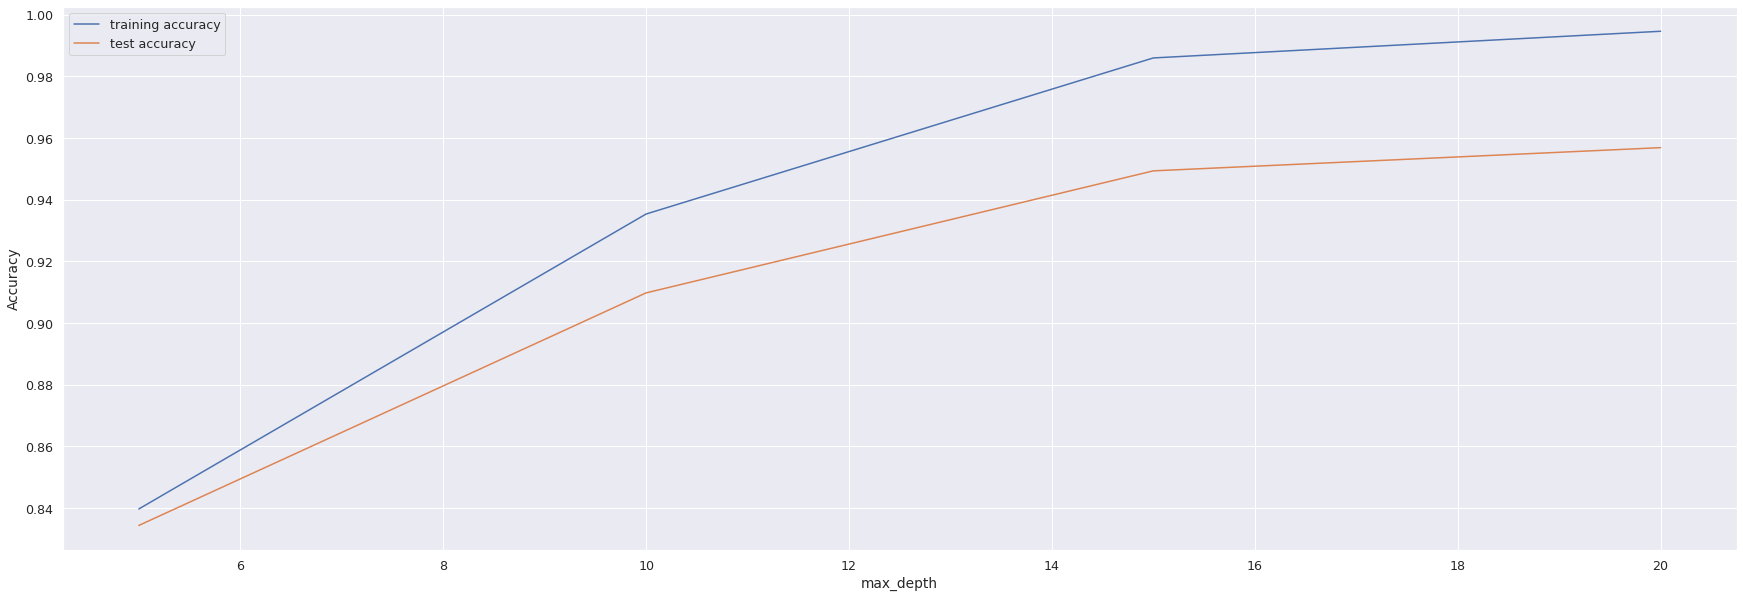

In [ ]:
# plotting accuracies with max_depth
plt.figure(figsize=(30,10))
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(1)
plt.show()

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [12,14],
    'min_samples_leaf': range(10, 50, 10),
    'min_samples_split': range(50, 100, 100),
    'n_estimators': [40,50], 
    'max_features': [15,20]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1,return_train_score=True)

In [ ]:
# Fit the grid search to the data
grid_search.fit(Xtrain[pca_col], y_train)

# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 10.0min finished


We can get accuracy of 0.9069818602947758 using {'max_depth': 14, 'max_features': 15, 'min_samples_leaf': 10, 'min_samples_split': 50, 'n_estimators': 50}


# Selecting Best  model parameters for Random Forest Classifier

In [ ]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=12,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             max_features=15,
                             n_estimators=50,n_jobs=-1)

In [ ]:
# fit
rfc.fit(Xtrain[pca_col],y_train)

# predict
y_predict = rfc.predict(Xtest[pca_col])

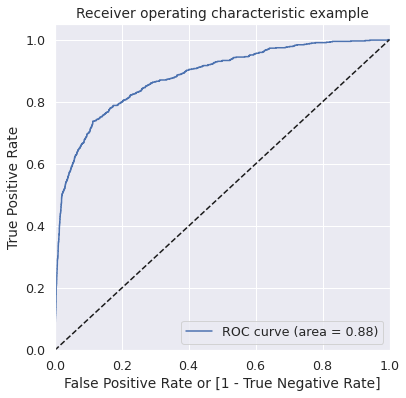


ROC of Random Forest using default configure :- 0.88


In [ ]:
pred_probs_test = rfc.predict_proba(Xtest[pca_col])
draw_roc(y_test,pred_probs_test[:,1])
print(f"\nROC of Random Forest using default configure :- {metrics.roc_auc_score(y_test, pred_probs_test[:,1]):2.2f}")

In [ ]:
# performance on train data
print('Performance on Training data using RF: ',rfc.score(Xtrain[pca_col], y_train))
# performance on test data
print('Performance on Testing data using RF:  ',rfc.score(Xtest[pca_col], y_test))
#Evaluate the model using accuracy, confusion metrix, and classification report
acc_RT=metrics.accuracy_score(y_test, y_predict)
print("Accuracy of Grid search RF:",acc_DT)
print('Confusion Matrix RF: \n',metrics.confusion_matrix(y_test, y_predict))
print('Classification report RF: \n',metrics.classification_report(y_test, y_predict))  

Performance on Training data using RF:  0.9047754996106929
Performance on Testing data using RF:   0.8889754143953721
Accuracy of Grid search RF: 0.9364779174546668
Confusion Matrix RF: 
 [[8150  107]
 [ 464  268]]
Classification report RF: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      8257
           1       0.71      0.37      0.48       732

    accuracy                           0.94      8989
   macro avg       0.83      0.68      0.73      8989
weighted avg       0.93      0.94      0.93      8989



In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['Random Forest'], 'accuracy': [acc_RT]},index={'4'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'accuracy']]
results

,Method,accuracy
1,Logistic Regression,0.833797
2,PCA,0.814774
3,Decision Tree,0.936478
4,Random Forest,0.936478


#High Performace AdaBoost Classifier

In [ ]:
adabst= AdaBoostClassifier(base_estimator=dt_model, n_estimators=100,random_state=rand_state)
adabst = adabst.fit(Xtrain, y_train)

In [ ]:
y_predict = adabst.predict(X_test)
acc_AB=metrics.accuracy_score(y_test, y_predict)
print('Accuracy using AdaBoosting: ',acc_AB)
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, y_predict))
print('Classification report AdaBoosting: \n',metrics.classification_report(y_test, y_predict))  

Accuracy using AdaBoosting:  0.9364779174546668
Confusion Matrix: 
 [[8150  107]
 [ 464  268]]
Classification report AdaBoosting: 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97      8257
           1       0.71      0.37      0.48       732

    accuracy                           0.94      8989
   macro avg       0.83      0.68      0.73      8989
weighted avg       0.93      0.94      0.93      8989



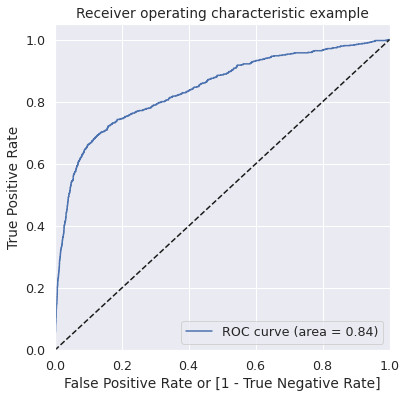


ROC of AdaBoost using default configure :- 0.84


In [ ]:
pred_probs_test = adabst.predict_proba(Xtest)
draw_roc(y_test,pred_probs_test[:,1])
print(f"\nROC of AdaBoost using default configure :- {metrics.roc_auc_score(y_test, pred_probs_test[:,1]):2.2f}")

In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['AdaBoost'], 'accuracy': acc_AB},index={'5'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'accuracy']]
results

,Method,accuracy
1,Logistic Regression,0.833797
2,PCA,0.814774
3,Decision Tree,0.936478
4,Random Forest,0.936478
5,AdaBoost,0.936478


#High Performace model XGBoost Classifier

In [ ]:
from xgboost import XGBClassifier

In [ ]:
model = XGBClassifier(random_state=rand_state)
model.fit(Xtrain, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=101,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

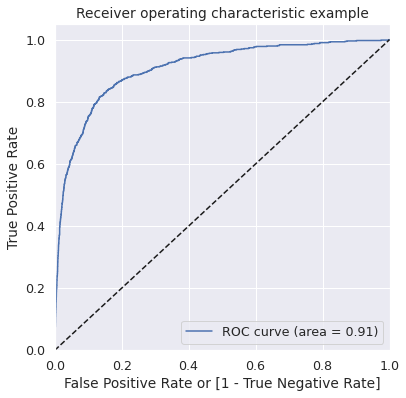


ROC of XGABoost :- 0.91


In [ ]:
pred_probs_test = model.predict_proba(Xtest)
draw_roc(y_test,pred_probs_test[:,1])
print(f"\nROC of XGABoost :- {metrics.roc_auc_score(y_test, pred_probs_test[:,1]):2.2f}")

In [ ]:
y_predict = model.predict(Xtest)
acc_XG=metrics.accuracy_score(y_test, y_predict)
print('Accuracy using XDABoosting: ',acc_XG)
print('Confusion Matrix: \n',metrics.confusion_matrix(y_test, y_predict))
print('Classification report XdaBoosting: \n',metrics.classification_report(y_test, y_predict))  

Accuracy using XDABoosting:  0.8992101457336745
Confusion Matrix: 
 [[7574  683]
 [ 223  509]]
Classification report XdaBoosting: 
               precision    recall  f1-score   support

           0       0.97      0.92      0.94      8257
           1       0.43      0.70      0.53       732

    accuracy                           0.90      8989
   macro avg       0.70      0.81      0.74      8989
weighted avg       0.93      0.90      0.91      8989



In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf = pd.DataFrame({'Method':['XGBoost'], 'accuracy': acc_XG},index={'6'})
results = pd.concat([results, tempResultsDf])
results = results[['Method', 'accuracy']]
results

,Method,accuracy
6,XGBoost,0.89921


# Step:8 Model Comparision and Metrics Evaluation

In [ ]:
print(results)

    Method  accuracy
6  XGBoost   0.89921


# Key Performance Index and Recommendations 

###Below are key parameters derived from Decision Tree

In [ ]:
total_ic_mou_8      0.455141
total_og_mou_7      0.002293

roam_og_mou_8       0.170058
av_rech_amt_data_8  0.135124
last_day_rch_amt_8  0.048608
total_og_mou_8      0.041615
roam_ic_mou_8       0.035865
total_rech_amt_8    0.035620
total_rech_num_8    0.015804
spl_og_mou_7        0.009571
loc_ic_mou_6        0.008537
loc_og_t2f_mou_7    0.008083


isd_ic_mou_6        0.004346
isd_og_mou_8        0.003738

loc_og_mou_8        0.004263

monthly_3g_6        0.003563
monthly_2g_7        0.002836

arpu_8              0.004830
arpu_2g_7           0.003228

sachet_3g_7         0.002337

ic_others_6         0.001915
vol_2g_mb_8         0.001871
loc_ic_t2f_mou_8    0.000753

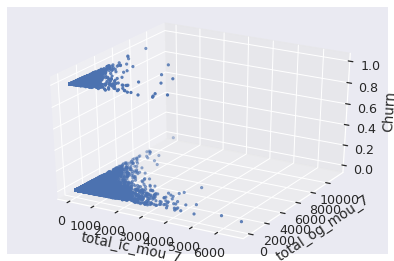

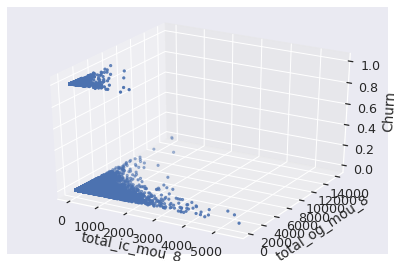

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221, projection='3d')
ax.scatter(hig_val_gh['total_ic_mou_7'],hig_val_gh['total_og_mou_7'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('total_ic_mou_7')
ax.set_ylabel('total_og_mou_7')
ax.set_zlabel('Churn')


# 'isd_ic_mou_6','isd_ic_mou_8',
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(221, projection='3d')
ax.scatter(hig_val_gh['total_ic_mou_8'],hig_val_gh['total_og_mou_8'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('total_ic_mou_8')
ax.set_ylabel('total_og_mou_8')
ax.set_zlabel('Churn')
plt.show()

plt.show()

####From the first 3 plot
1.   If the min of usage of total incoming call in the month of 7 is less than 1000, Churn changes are high
2.   


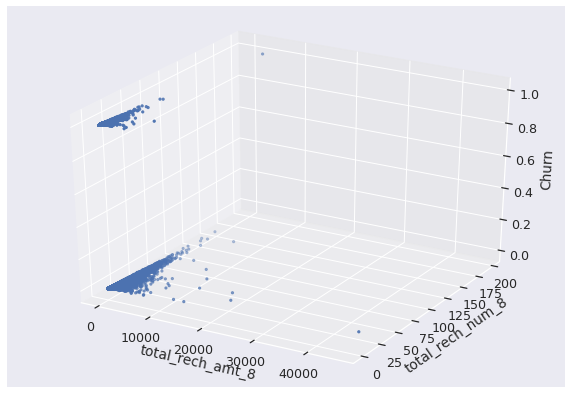

In [ ]:
# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hig_val_gh['total_rech_amt_8'],hig_val_gh['total_rech_num_8'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('total_rech_amt_8')
ax.set_ylabel('total_rech_num_8')
ax.set_zlabel('Churn')

plt.show()

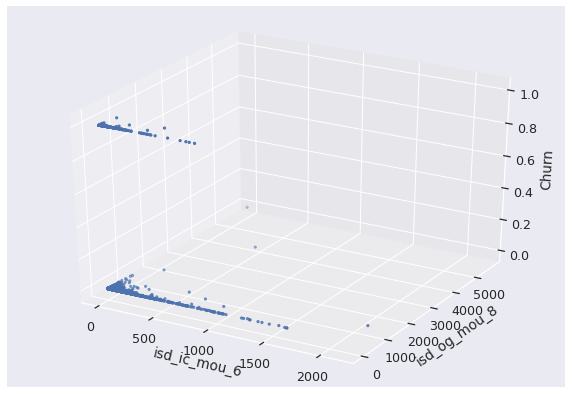

In [ ]:
# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hig_val_gh['isd_ic_mou_6'],hig_val_gh['isd_og_mou_8'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('isd_ic_mou_6')
ax.set_ylabel('isd_og_mou_8')
ax.set_zlabel('Churn')

plt.show()

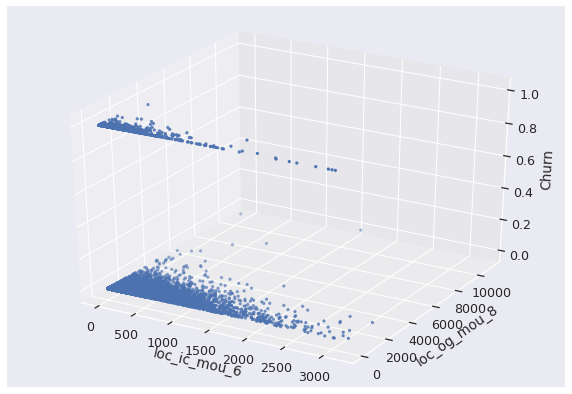

In [ ]:
# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hig_val_gh['loc_ic_mou_6'],hig_val_gh['loc_og_mou_8'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('loc_ic_mou_6')
ax.set_ylabel('loc_og_mou_8')
ax.set_zlabel('Churn')

plt.show()

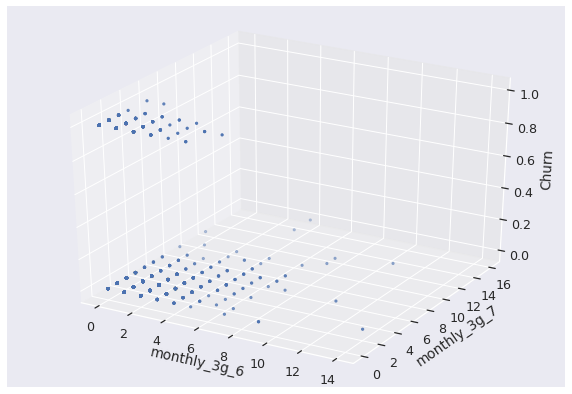

In [ ]:
# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hig_val_gh['monthly_3g_6'],hig_val_gh['monthly_3g_7'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('monthly_3g_6')
ax.set_ylabel('monthly_3g_7')
ax.set_zlabel('Churn')

plt.show()

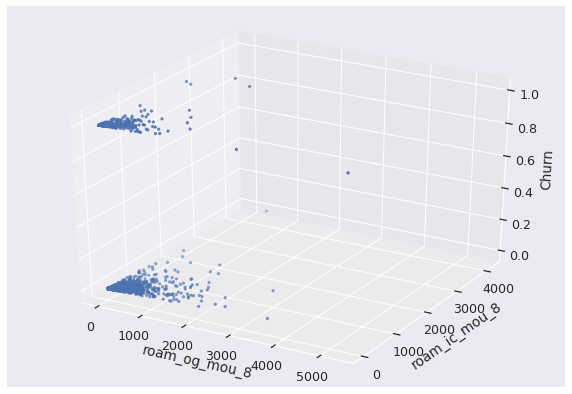

In [ ]:
# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hig_val_gh['roam_og_mou_8'],hig_val_gh['roam_ic_mou_8'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('roam_og_mou_8')
ax.set_ylabel('roam_ic_mou_8')
ax.set_zlabel('Churn')

plt.show()

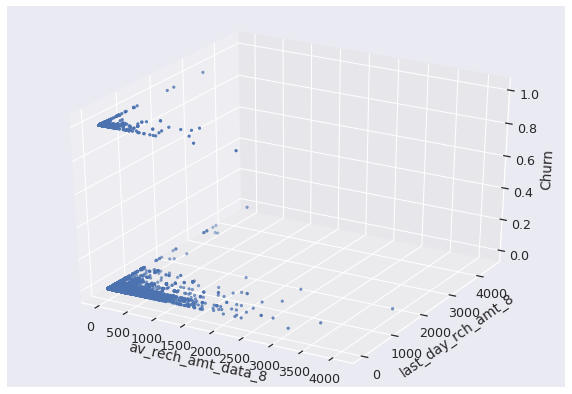

In [ ]:
# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hig_val_gh['av_rech_amt_data_8'],hig_val_gh['last_day_rch_amt_8'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('av_rech_amt_data_8')
ax.set_ylabel('last_day_rch_amt_8')
ax.set_zlabel('Churn')

plt.show()

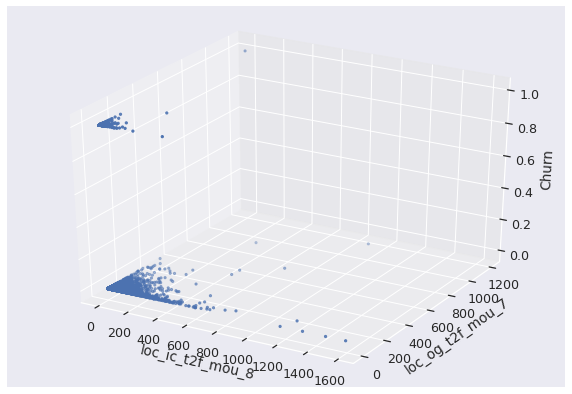

14.350221955208623
6.424072627749299


In [ ]:
# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hig_val_gh['loc_ic_t2f_mou_8'],hig_val_gh['loc_og_t2f_mou_7'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('loc_ic_t2f_mou_8')
ax.set_ylabel('loc_og_t2f_mou_7')
ax.set_zlabel('Churn')

plt.show()

print(hig_val_gh['loc_ic_t2f_mou_8'].mean())
print(hig_val_gh['loc_og_t2f_mou_7'].mean())

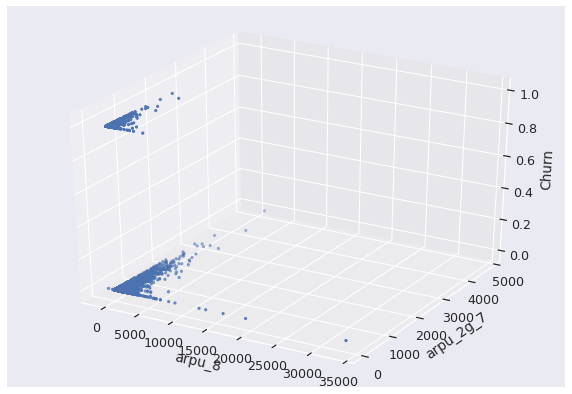

508.5017495076954
64.7024401722233


In [ ]:
# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hig_val_gh['arpu_8'],hig_val_gh['arpu_2g_7'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('arpu_8')
ax.set_ylabel('arpu_2g_7')
ax.set_zlabel('Churn')

plt.show()

print(hig_val_gh['arpu_8'].mean())
print(hig_val_gh['arpu_2g_7'].mean())


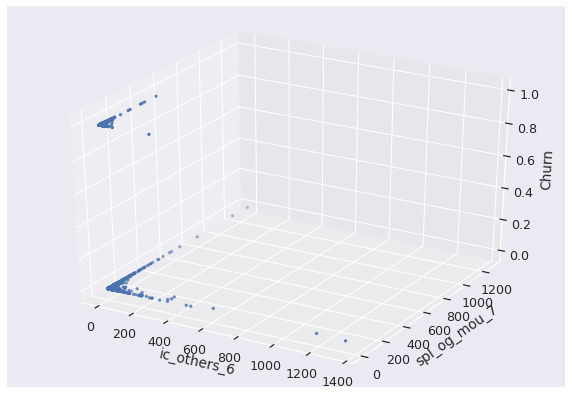

1.146292513601024
7.109950602449681


In [ ]:
# 'ic_others_6','ic_others_8',
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hig_val_gh['ic_others_6'],hig_val_gh['spl_og_mou_7'],hig_val_gh['churn'], c='b', marker='.')
ax.set_xlabel('ic_others_6')
ax.set_ylabel('spl_og_mou_7')
ax.set_zlabel('Churn')

plt.show()

print(hig_val_gh['ic_others_6'].mean())
print(hig_val_gh['spl_og_mou_7'].mean())


In [ ]:
EDA & Recommendations:

total_ic_mou_8 :  
total Incoming calls Minutes of usage - voice calls in 8th Monthvvalue less than : 1000	minutes ; 
there are higher chances of customer churn

total_og_mou_8 : total Outgoing calls Minutes of usage - voice calls in 8th Month
value less than : 4000 minutes ;
there are higher chances of customer churn

total_og_mou_7 : total Incoming calls Minutes of usage - voice calls in 7th Month
value less than : 		 minutes ;
there are higher chances of customer churn

total_rech_amt_8 : total recharge amount in 8th Month
value less than : 500 value ; there are higher chances of customer churn

total_rech_num_8 : total recharge count in 8th Month
value less than : 75 counts ; there are higher chances of customer churn

loc_ic_mou_6 : Local incoming minutes of usage - voice calls in 6th Month
value less than : 1500 minutes ; there are higher chances of customer churn

loc_og_mou_8 : Local incoming minutes of usage - voice calls in 6th Month
value less than : 2000 minutes ; there are higher chances of customer churn

monthly_3g_6 : 3G data usage in 6th Month
value less than : 4; there are higher chances of customer churn

monthly_2g_7 : 2G data usage in 6th Month
value less than : 2; there are higher chances of customer churn

roam_og_mou_8 : Roaming outgoing minutes of usage in 8th Month
value less than : 1000 minutes ; there are higher chances of customer churn

roam_ic_mou_8 : Roaming Incoming minutes of usage in 8th Month
value less than : 500 minutes ; there are higher chances of customer churn

av_rech_amt_data_8 : Average recharge amount in 8th Month
value less than : 1000 amount ; there are higher chances of customer churn

last_day_rch_amt_8 : Last day recharge amount in 8th Month
value less than : 500 amount ; there are higher chances of customer churn

vol_2g_mb_8 : 2G Data volume in 8th Month
value less than : 		 minutes ; there are higher chances of customer churn

isd_ic_mou_6 : ISD incoming calls - minutes of usage in 6th Month
value less than : 500 minutes ; there are higher chances of customer churn

isd_og_mou_8 : ISD Outoming calls - minutes of usage in 8th Month
value less than : 100 minutes ; there are higher chances of customer churn

loc_ic_t2f_mou_8 : Local incoming T to F minutes of usage in 8th Month
value less than : 200 minutes ; there are higher chances of customer churn

loc_ic_t2f_mou_7 : Local incoming T to F minutes of usage in 7th Month
value less than : 		 minutes ; there are higher chances of customer churn

arpu_8 : Average revenue per user in 8th Month
value less than : 5000 amount ; there are higher chances of customer churn

arpu_2g_7 : Average revenue per user in 7th Month for 2G
value less than : 2500 minutes ; there are higher chances of customer churn

ic_others_6 : Incoming calls in 6th Month
value less than : 100 minutes ; there are higher chances of customer churn

spl_og_mou_7 : Special outgoing calls - minutes of usage in 7th Month
value less than : 200 minutes ; there are higher chances of customer churn